In [42]:
!unzip Dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import cv2
from tensorflow.keras.preprocessing import image

In [44]:
train_data_dir = 'F:/Wound Healing Prediction/Wound/Dataset/train'
test_data_dir = 'F:/Wound Healing Prediction/Wound/Dataset/test'
valid_data_dir = 'F:/Wound Healing Prediction/Wound/Dataset/valid'

In [45]:
img_height, img_width = 224, 224
batch_size = 16

# Data augmentation for training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data augmentation for test and validation set (only rescaling)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [46]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load validation data
valid_generator = test_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 220 images belonging to 2 classes.


Found 60 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [47]:
# Check the number of classes
total_classes = len(train_generator.class_indices)
print("Detected Classes:", train_generator.class_indices)

# Load MobileNetV2 pre-trained model without top (classification) layers
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(total_classes, activation='softmax')(x)  # Dynamically set output size

Detected Classes: {'normal': 0, 'wounds': 1}


In [48]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

# Evaluate the model on the test set
print("Evaluating model on test data...")
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc * 100)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 806ms/step - accuracy: 0.6072 - loss: 8.8175 - val_accuracy: 0.9091 - val_loss: 0.7389
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 583ms/step - accuracy: 0.8588 - loss: 0.6584 - val_accuracy: 0.9773 - val_loss: 0.1627
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - accuracy: 0.9150 - loss: 0.3242 - val_accuracy: 0.9545 - val_loss: 0.1568
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 550ms/step - accuracy: 0.9491 - loss: 0.1780 - val_accuracy: 0.9773 - val_loss: 0.0205
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - accuracy: 0.9676 - loss: 0.0839 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 547ms/step - accuracy: 0.9626 - loss: 0.1190 - val_accuracy: 1.0000 - val_loss: 0.0250
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 566ms/step - accuracy: 0.9639 - loss: 0.0714 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step - accuracy: 0.9617 - loss: 0.0710 - val_accuracy: 1

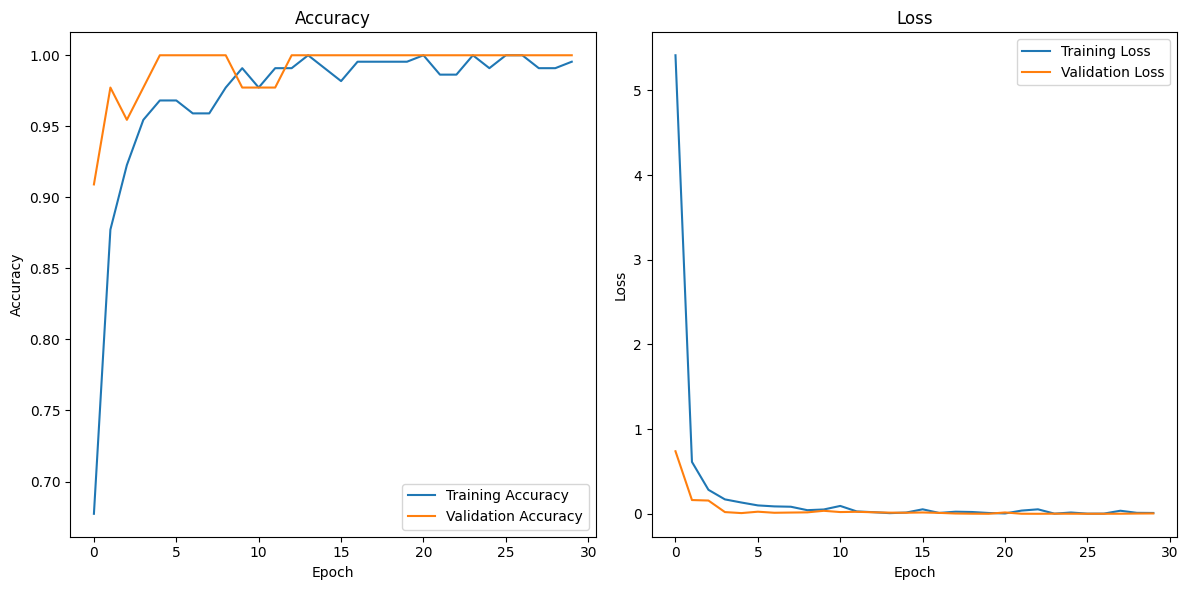

In [49]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Save the model
model.save('wound_recovery_model.h5')

# Load the saved model
custom_model = tf.keras.models.load_model('wound_recovery_model.h5')

In [51]:
'''test_image_path = 'F:\Wound Healing Prediction\Wound\Sample3.jpg'  # Replace with the path to your test image
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height,img_width))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)

# Preprocess the image for prediction
img = img / 255.0  # Rescale to [0, 1]

# Make predictions
predictions = custom_model.predict(img)

# Assuming your classes are detected dynamically
class_names = list(train_generator.class_indices.keys())
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

print(f"The image is classified as: {predicted_class}")
#print(f"Prediction probabilities: {predictions[0]}")

# Display class probabilities
for i in range(len(class_names)):
    print(f"{class_names[i]}: {predictions[0][i]}")'''

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\datch\AppData\Local\Temp\ipykernel_24340\1763955737.py:1: SyntaxWarning: invalid escape sequence '\W'
  '''test_image_path = 'F:\Wound Healing Prediction\Wound\Sample3.jpg'  # Replace with the path to your test image


'test_image_path = \'F:\\Wound Healing Prediction\\Wound\\Sample3.jpg\'  # Replace with the path to your test image\nimg = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height,img_width))\nimg = tf.keras.preprocessing.image.img_to_array(img)\nimg = np.expand_dims(img, axis=0)\n\n# Preprocess the image for prediction\nimg = img / 255.0  # Rescale to [0, 1]\n\n# Make predictions\npredictions = custom_model.predict(img)\n\n# Assuming your classes are detected dynamically\nclass_names = list(train_generator.class_indices.keys())\npredicted_class_index = np.argmax(predictions)\npredicted_class = class_names[predicted_class_index]\n\nprint(f"The image is classified as: {predicted_class}")\n#print(f"Prediction probabilities: {predictions[0]}")\n\n# Display class probabilities\nfor i in range(len(class_names)):\n    print(f"{class_names[i]}: {predictions[0][i]}")'

In [52]:
# Load the saved model (Ensure you have saved it previously)
model_path = "F:/Wound Healing Prediction/Wound/wound_recovery_model.h5"  # Update path if needed
model = tf.keras.models.load_model(model_path)

# Define image dimensions
img_height, img_width = 224, 224

In [53]:
# Define class names (Make sure it matches your trained classes)
class_names = ["No Wound", "Moderate Wound", "Severe Wound"]

# Healing period estimation (days)
healing_periods = {
    "No Wound": "You are alright!",
    "Moderate Wound": "Estimated healing period: 7-14 days",
    "Severe Wound": "Estimated healing period: 15-30 days or requires medical attention"
}

In [54]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array, img

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


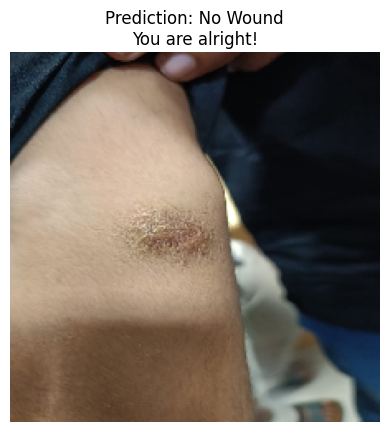

Predicted Class: No Wound
You are alright!


In [55]:
def predict_wound(img_path):
    img_array, img = preprocess_image(img_path)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Display results
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\n{healing_periods[predicted_class]}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Class: {predicted_class}")
    print(f"{healing_periods[predicted_class]}")

# Provide the image path
test_image_path = "F:/Wound Healing Prediction/Wound/Sample3.jpg"  # Update with your test image
predict_wound(test_image_path)

import matplotlib.patches as patches

if predicted_class in class_names[:-1]:  # If not severe, just display the image
    img = tf.keras.preprocessing.image.load_img(test_image_path)
    plt.imshow(img)
    plt.title(f'{predicted_class} Wound')
    plt.show()

elif predicted_class == class_names[-1]:  # Severe case with bounding box
    severe_img_path = test_image_path
    severe_img = tf.keras.preprocessing.image.load_img(severe_img_path)
    severe_img = tf.keras.preprocessing.image.img_to_array(severe_img)

    # Example bounding box coordinates (adjust as needed)
    x, y, w, h = 100, 100, 200, 200

    plt.imshow(severe_img / 255.0)
    plt.title('Severe Wound with Bounding Box')
    plt.gca().add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
    plt.show()